# Evaluate the performance of the models

In [146]:
# import all of the packages that will be used

# basic packages for data processing
import pandas as pd
import numpy as np

# packege for calculation
import math

# packages for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# packages to interpret the training result
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# package to benchmark the CPU running time
from time import process_time

# silent the warning from sklearn package
# import warnings
# warnings.filterwarnings('ignore')

# set the random seed to ensure the result is reproducible
import random
random.seed(10)
np.random.seed(10)

In [147]:
features = pd.read_csv('Dataset/features_selected/CIC-IDS2017_RandomForestClassifier_20.csv').squeeze()
features = features[:11]

## Load the dataset

In this notebook, both the training dataset and the testing dataset are used. 

In [148]:
columns = features.tolist() +  ['Label']

ids2017 = pd.read_csv('Dataset/dataset_cleaned/CIC-IDS2017.csv', usecols=columns)
ids2017.shape

(649762, 12)

In [149]:
# load the ids2018 dataset for model evaluation
ids2018 = pd.read_csv('Dataset/dataset_cleaned/CSE-CIC-IDS2018.csv', usecols=columns)
ids2018.shape

(515582, 12)

## Additional Processing

In [150]:
ids2017 = ids2017.sample(frac=0.1).reset_index(drop=True)
ids2018 = ids2018.sample(frac=0.1).reset_index(drop=True)

### Split the features and the labels

Split the features and the output variable. The CIC-IDS2017 dataset will be further split into training and testinng dataset to compare the accuracy with the CSE-CIC-IDS2018 dataset. 

In [151]:
ids2017_X = ids2017.drop('Label', axis=1).copy()
ids2017_y = ids2017['Label'].copy()

ids2017_train_X, ids2017_test_X, ids2017_train_y, ids2017_test_y = train_test_split(ids2017_X, ids2017_y, test_size=0.3)

In [152]:
ids2018_X = ids2018.drop('Label', axis=1).copy()
ids2018_y = ids2018['Label'].copy()

### Data scaling

In [153]:
scalar = StandardScaler()
# only fit the training data
ids2017_train_X_scaled = scalar.fit(ids2017_train_X)

ids2017_train_X_scaled = scalar.transform(ids2017_train_X)
ids2017_test_X_scaled = scalar.transform(ids2017_test_X)
ids2018_X_scaled = scalar.transform(ids2018_X)

## Build the ultimate models

In [154]:
models = {
    'Decision Tree': tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=1.4401469385343852e-05),
    'Random Forest': RandomForestClassifier(max_depth=20, min_samples_leaf=0.00001, min_samples_split=0.00001, n_estimators=350, n_jobs=-1,criterion='gini'),
    'Support Vector Machine': SVC(C=100, gamma=1, kernel='rbf'),
    'Naive Bayes': GaussianNB(var_smoothing=1.0),
    'Artificial Neural Network': MLPClassifier(hidden_layer_sizes=(50,), activation='tanh', alpha=0.0001, solver='adam', max_iter=1000),
    'Deep Neural Network': MLPClassifier(hidden_layer_sizes=(15, 15, 15), activation='tanh', alpha=1e-05, solver='adam', max_iter=1000)
}

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign     0.9987    0.9932    0.9959      9824
   malicious     0.9931    0.9987    0.9959      9669

    accuracy                         0.9959     19493
   macro avg     0.9959    0.9959    0.9959     19493
weighted avg     0.9959    0.9959    0.9959     19493

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.9990    0.9945    0.9967      9824
   malicious     0.9944    0.9990    0.9967      9669

    accuracy                         0.9967     19493
   macro avg     0.9967    0.9967    0.9967     19493
weighted avg     0.9967    0.9967    0.9967     19493

------------------------- Support Vector Machine -------------------------
              precision    recall  f1-score   support

      benign     0.9923    0.9278    0.9590      9824
   malicious     0.9312    0.9

Text(0.5, 0.98, 'Confusion matrix of each model on CIC-IDS2017 dataset')

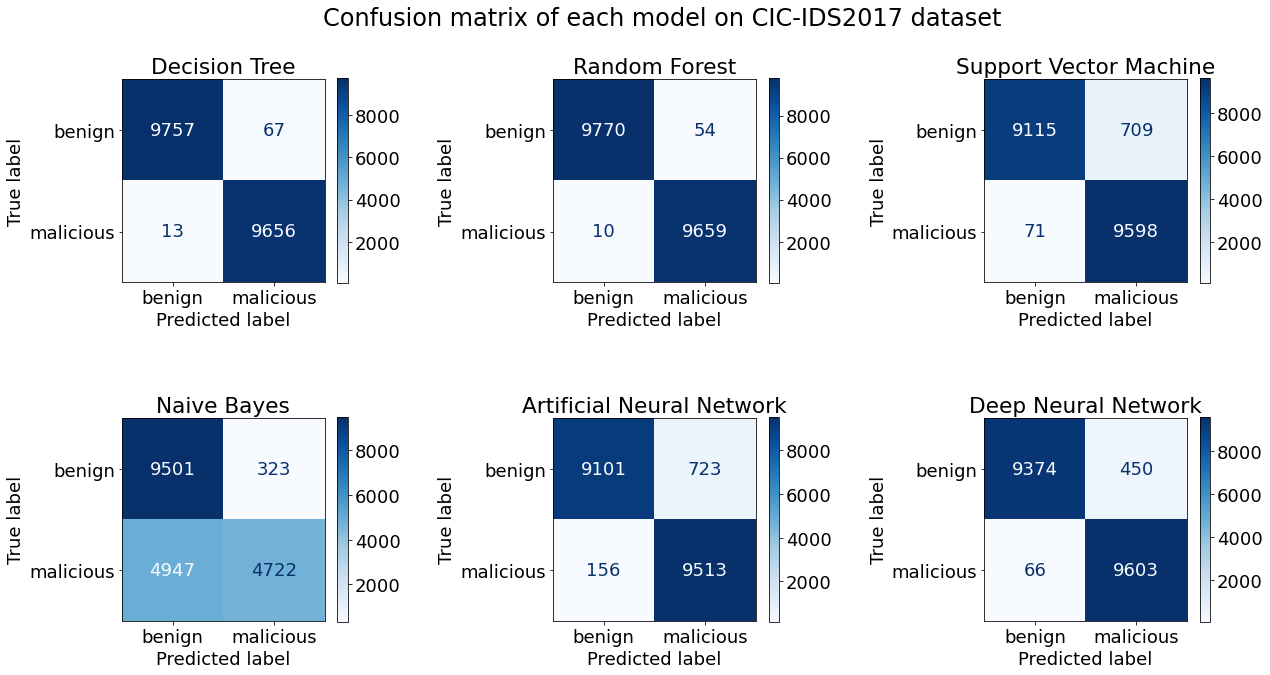

In [155]:
trained_models = {}
training_time = {}
accuracy_train_dataset = {}
f_score_train_dataset = {}

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(models.items()):

    training_start_time = process_time()
    clf.fit(ids2017_train_X_scaled, ids2017_train_y)

    # save the training time
    training_time[model] = process_time() - training_start_time

    # save the trained model
    trained_models[model] = clf

    prediction = clf.predict(ids2017_test_X_scaled)
    model_report = metrics.classification_report(ids2017_test_y, prediction, digits=4, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_train_dataset[model] = model_report['accuracy']
    f_score_train_dataset[model] = model_report['weighted avg']['f1-score']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(ids2017_test_y, prediction, digits=4))

    plot_confusion_matrix(clf, 
                            ids2017_test_X_scaled, 
                            ids2017_test_y, 
                            cmap=plt.cm.Blues,
                            ax=axes[math.floor(i/3)][i%3])

    axes[math.floor(i/3)][i%3].set_title(model)


fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CIC-IDS2017 dataset', fontsize=24)

# Evaluate the model using CSE-CIC-2018 dataset

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign     0.5546    0.9660    0.7046     25835
   malicious     0.8660    0.2208    0.3518     25723

    accuracy                         0.5942     51558
   macro avg     0.7103    0.5934    0.5282     51558
weighted avg     0.7099    0.5942    0.5286     51558

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign     0.5550    0.9668    0.7052     25835
   malicious     0.8690    0.2214    0.3529     25723

    accuracy                         0.5949     51558
   macro avg     0.7120    0.5941    0.5290     51558
weighted avg     0.7116    0.5949    0.5294     51558

------------------------- Support Vector Machine -------------------------
              precision    recall  f1-score   support

      benign     0.6977    0.9049    0.7879     25835
   malicious     0.8639    0.6

Text(0.5, 0.98, 'Confusion matrix of each model on CSE-CIC-IDS2018 dataset')

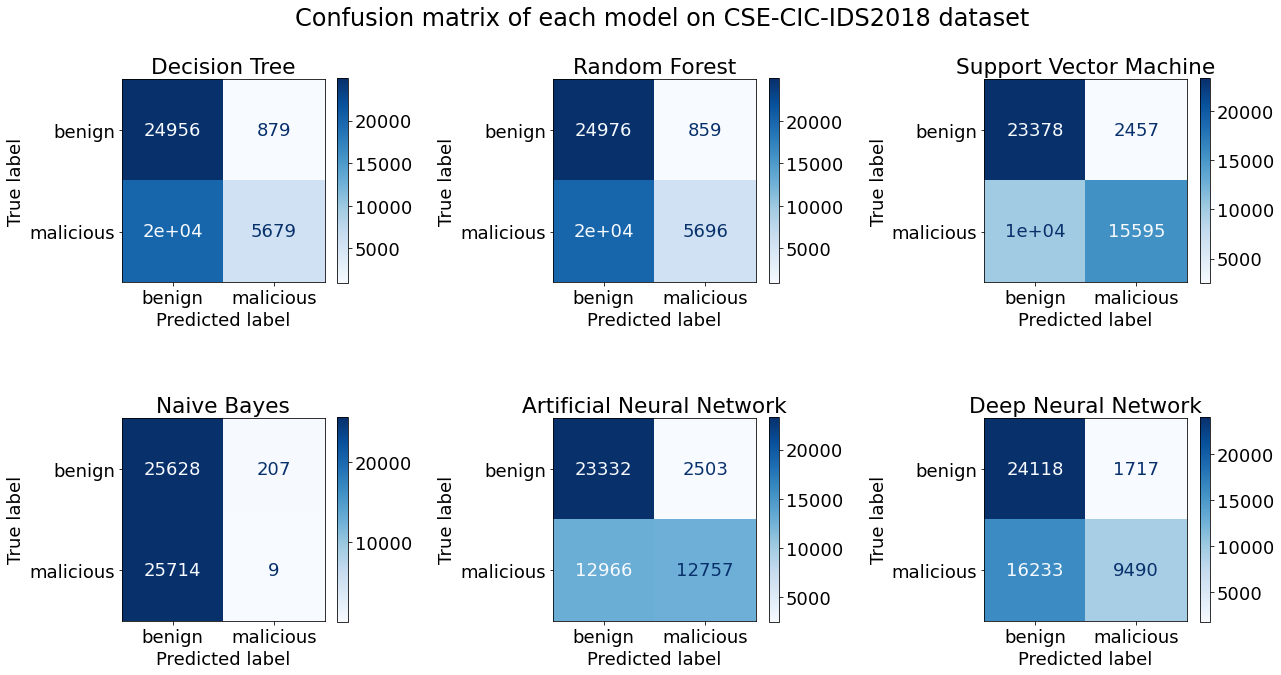

In [156]:
prediction_time = {}
accuracy_testing_dataset = {}
f_score_testing_dataset = {}

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (model, clf) in enumerate(trained_models.items()):

    prediction_start_time = process_time()
    prediction = clf.predict(ids2018_X_scaled)

    # save the time consumption for prediction
    prediction_time[model] = process_time() - prediction_start_time

    model_report = metrics.classification_report(ids2018_y, prediction, digits=4, output_dict=True)
    
    # save the accuracy and the f1-score of each model
    accuracy_testing_dataset[model] = model_report['accuracy']
    f_score_testing_dataset[model] = model_report['weighted avg']['f1-score']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(ids2018_y, prediction, digits=4))

    plot_confusion_matrix(clf, 
                            ids2018_X_scaled, 
                            ids2018_y, 
                            cmap=plt.cm.Blues,
                            ax=axes[math.floor(i/3)][i%3])

    axes[math.floor(i/3)][i%3].set_title(model)


fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Confusion matrix of each model on CSE-CIC-IDS2018 dataset', fontsize=24)

## Comparison

In this section, comparison between models will be done in terms of accuracy and f1-score. Besides that, the time consumed by each model for training and predicting the testing data will be compared.

In [157]:
# define function to create label on top of the bars
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, f"{height:.2f}", ha='center', va='bottom')

### Accuracy

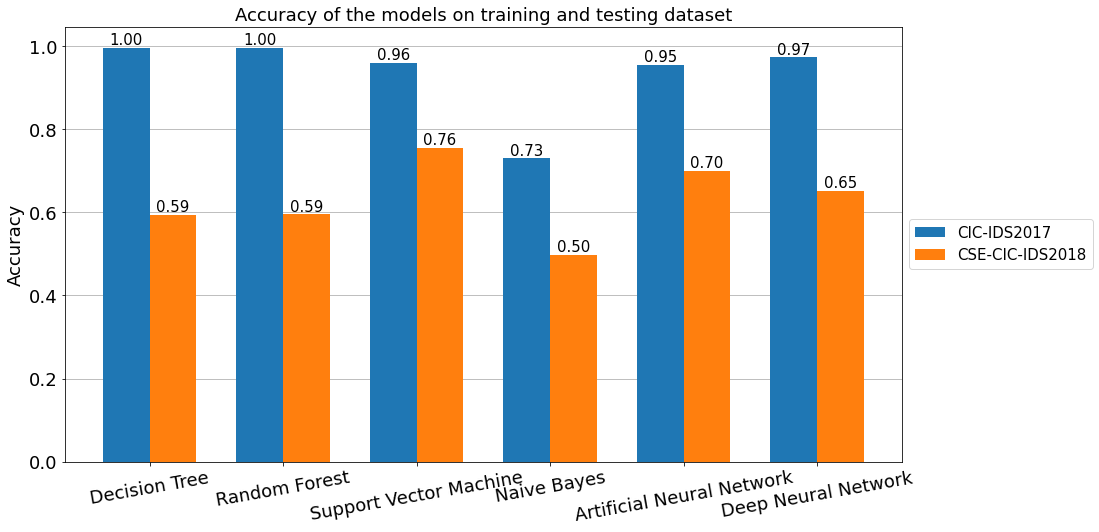

In [158]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(accuracy_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, accuracy_train_dataset.values(), width, label='CIC-IDS2017')
bar2 = ax.bar(x + width/2, accuracy_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

plt.show()

### F1-score

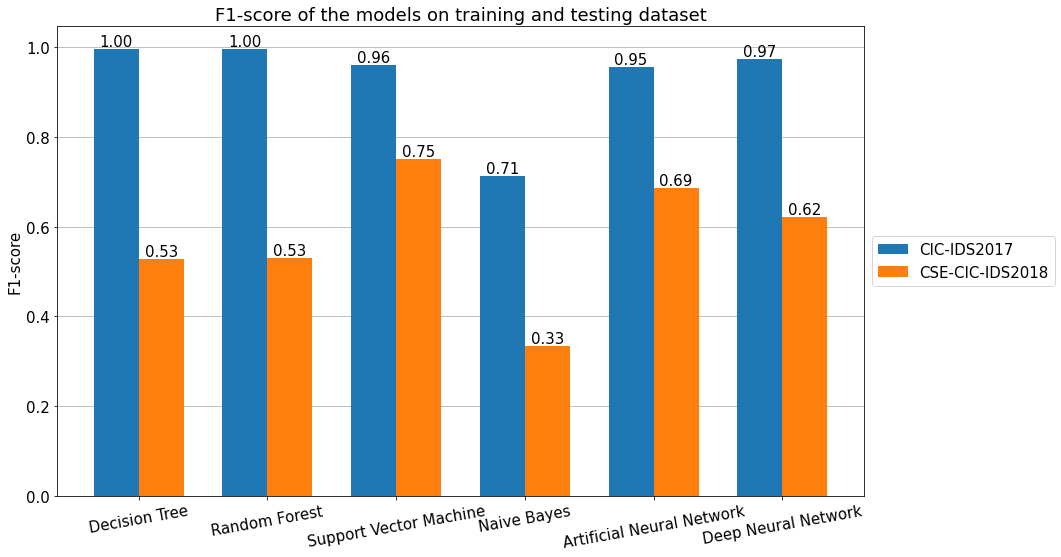

In [159]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(f_score_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, f_score_train_dataset.values(), width, label='CIC-IDS2017')
bar2 = ax.bar(x + width/2, f_score_testing_dataset.values(), width, label='CSE-CIC-IDS2018')

ax.set_ylabel('F1-score')
ax.set_title('F1-score of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(f_score_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

fig.tight_layout()

plt.show()

### Time consumption for training

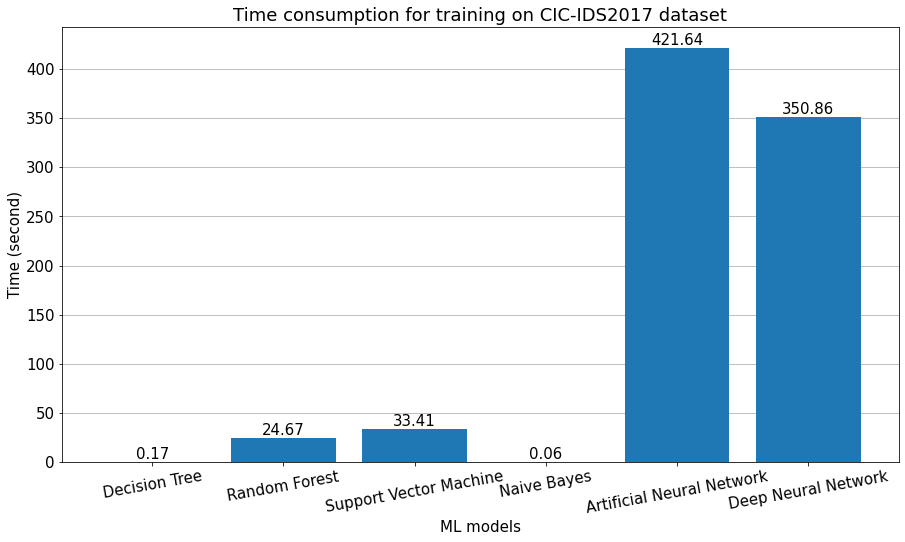

In [160]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(training_time.keys(), training_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Time consumption for training on CIC-IDS2017 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()

### Time consumption for prediction

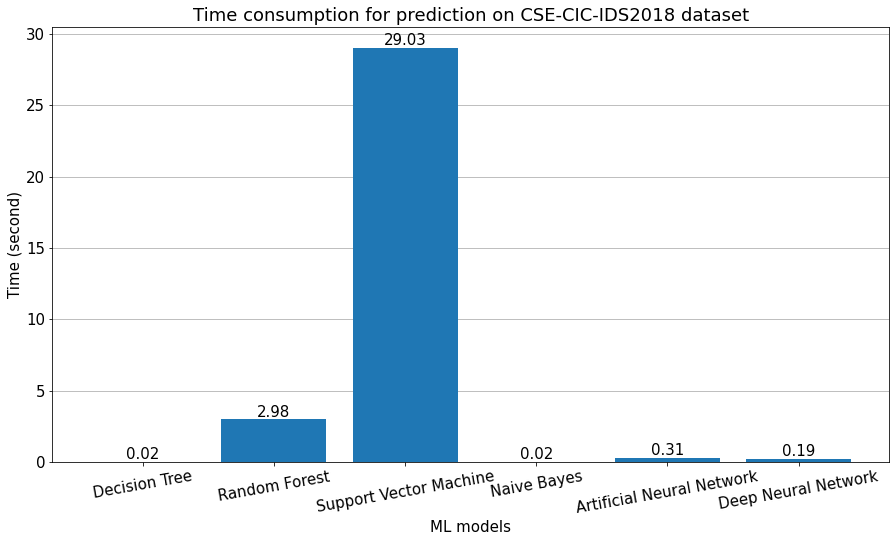

In [161]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(prediction_time.keys(), prediction_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Time consumption for prediction on CSE-CIC-IDS2018 dataset")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()